In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

### Training Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip to a local directory
local_zip = '/content/drive/MyDrive/Food_Classification/images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
# Define parameters
img_height=224
img_width=224
batch_size=8

# Define data directories
# data_train_dir = "/content/drive/MyDrive/Food Object Detection/dataset/train"
# data_val_dir = "/content/drive/MyDrive/Food Object Detection/dataset/valid"

# Define data directories
data_train_dir = "./dataset/train"
data_val_dir = "./dataset/valid"

Since the dataset isn't very large, with only 1325 images in the training set, we've opted for a smaller batch size of 8 and an image size of 224x224. This decision aims to facilitate better learning for the model.

In [ ]:
# Data augmentation and preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

# Data preprocessing for validation set (without augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow data from directories for training set
train_generator = train_datagen.flow_from_directory(
    data_train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow data from directories for validation set
validation_generator = val_datagen.flow_from_directory(
    data_val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9154 images belonging to 10 classes.
Found 1458 images belonging to 10 classes.


In [ ]:
# Set training seed so we can reproduce the result
tf.random.set_seed(42)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width,img_height,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


After experimenting with various transfer learning architectures such as VGG16, VGG19, and Inception, I've found that MobileNetV2 tends to provide superior predictions. Moreover, MobileNetV2 is well-suited for mobile applications due to its optimized structure and efficient performance.

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Define the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)),
    # layers.BatchNormalization(),
    # layers.Dropout(0.5),  # Dropout at 50%
    layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)),
    # layers.BatchNormalization(),
    # layers.Dropout(0.5),  # Dropout at 50%
    layers.Dense(5, activation='softmax', kernel_initializer='glorot_uniform')
])

initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.95

# Define the exponential decay learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# Initialize the Adam optimizer with the learning rate schedule
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


I've observed instances where the model exhibits high initial accuracy, approximately around 90%, but subsequent performance drops significantly to around 10%. To address this, I've opted to use Glorot uniform initialization to ensure that the model starts gradient descent from an optimal position. Additionally, I've incorporated a decay rate to facilitate faster convergence to local optima and reduce noise in the optimizer's trajectory.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2619461 (9.99 MB)
Trainable params: 3614


Create a callback function to save the highest average accuracy achieved during training and validation.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
import os

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq=5):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            avg_acc = (logs.get('accuracy') + logs.get('val_accuracy')) / 2
            filepath = self.filepath.format(epoch=epoch + 1, avg_acc=avg_acc)
            self.model.save(filepath)
            print(f"Model saved to {filepath}")

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Set up custom model checkpoint to save the model with the average accuracy in the filename
custom_model_checkpoint = CustomModelCheckpoint(
    filepath='model_epoch_{epoch:02d}_avg_acc_{avg_acc:.2f}.h5',
    save_freq=5
)


In [ ]:
# # Compile the model
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model with early stopping and custom model checkpoint callbacks
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, custom_model_checkpoint]
)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-23-b2252f5ba714>", line 7, in <cell line: 7>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[8,5] labels_size=[8,10]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_10174]

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, "models.keras")

In [ ]:
model.save('./model.h5')

In [ ]:
history.history

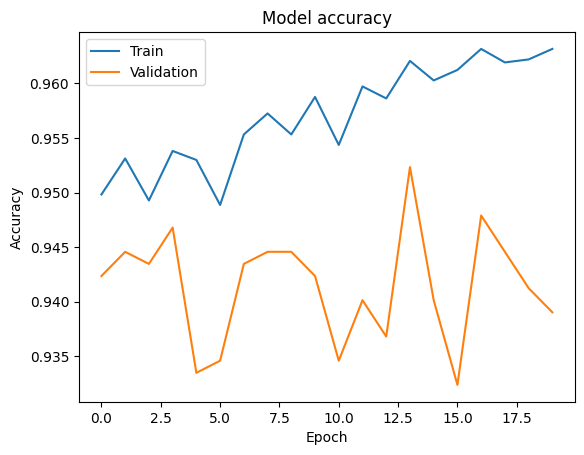

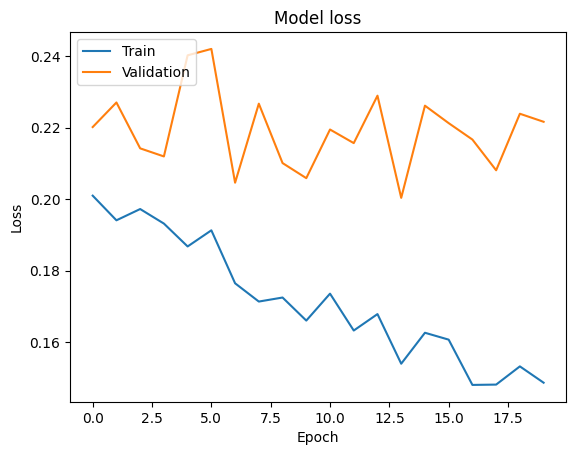

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)


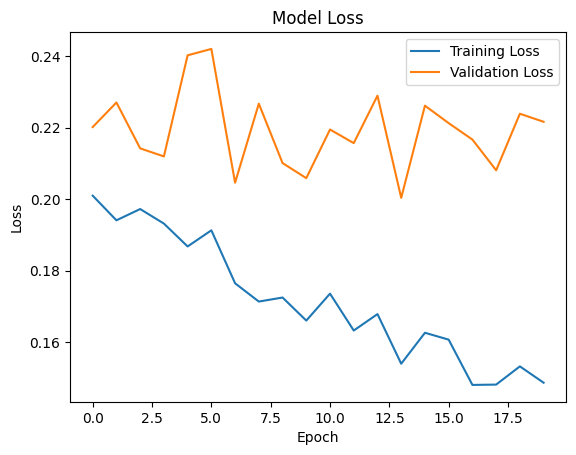

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming 'history' is the history object returned from model.fit()
plot_loss(history)


### Test The Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def plot_image_with_prediction(model, image_path, class_indices):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)

    predicted_class_index = np.argmax(prediction)
    predicted_class = list(class_indices.keys())[predicted_class_index]
    predicted_prob = prediction[0][predicted_class_index]

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

    plt.title(f'Predicted: {predicted_class} ({predicted_prob:.2f})')
    plt.show()

1/1 [==============================] - 1s 1s/step


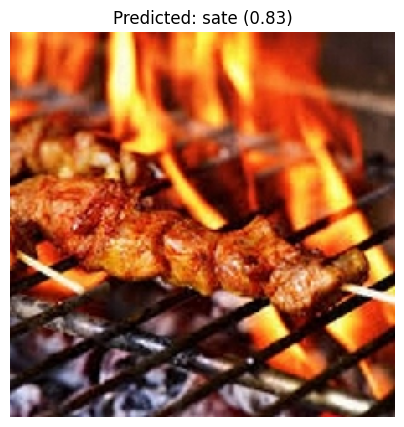

Actual Label: sate
1/1 [==============================] - 0s 61ms/step


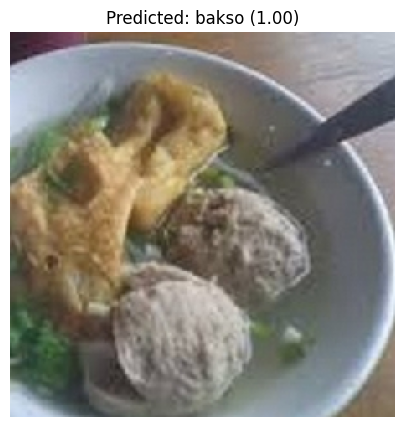

Actual Label: bakso
1/1 [==============================] - 0s 95ms/step


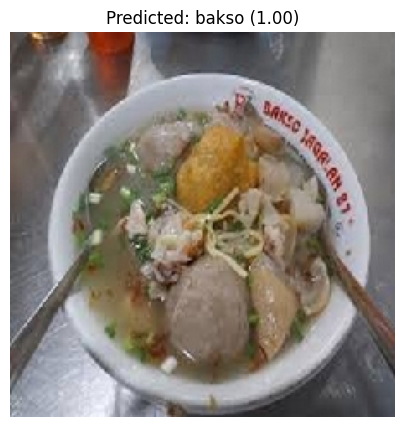

Actual Label: bakso
1/1 [==============================] - 0s 86ms/step


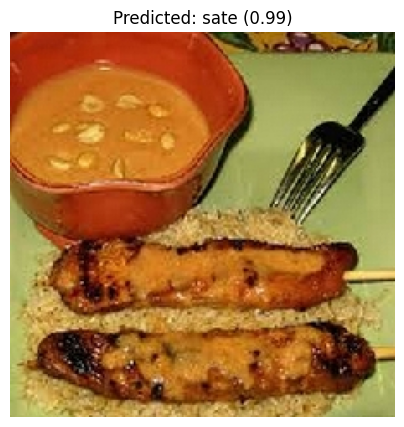

Actual Label: sate
1/1 [==============================] - 0s 55ms/step


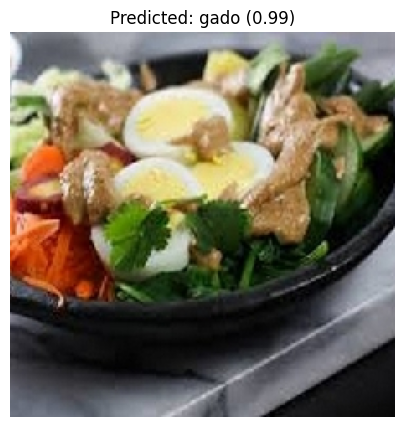

Actual Label: gado
1/1 [==============================] - 0s 125ms/step


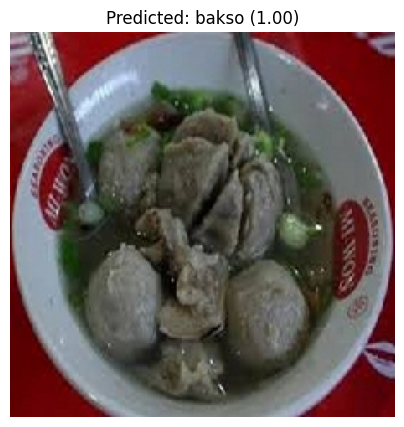

Actual Label: bakso
1/1 [==============================] - 0s 113ms/step


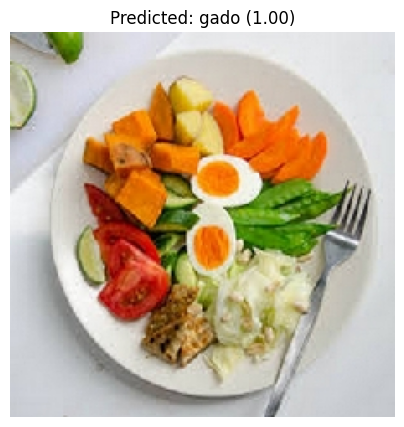

Actual Label: gado
1/1 [==============================] - 0s 51ms/step


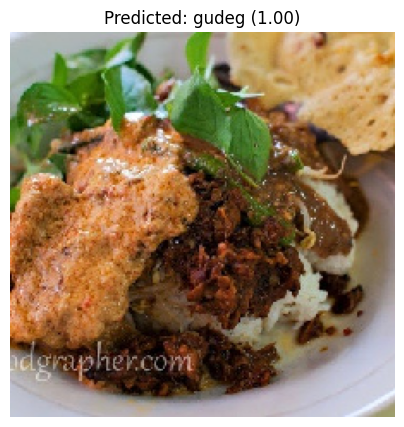

Actual Label: gudeg
1/1 [==============================] - 0s 67ms/step


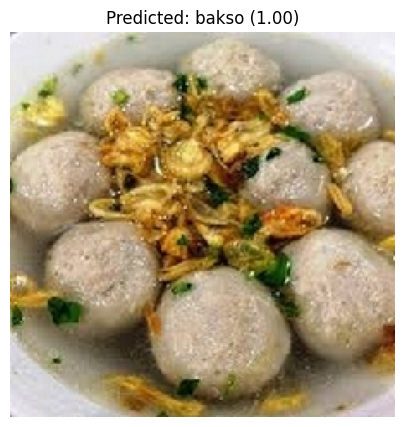

Actual Label: bakso
1/1 [==============================] - 0s 75ms/step


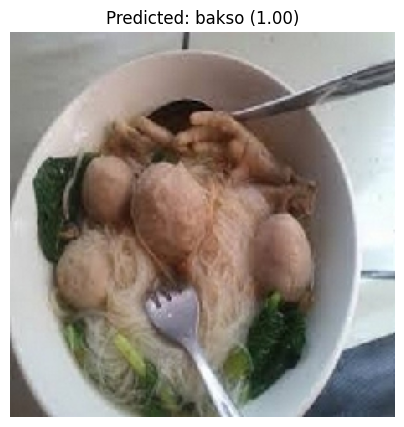

Actual Label: bakso


In [ ]:
import os
import random


dataset_dir = '/content/drive/MyDrive/Food Object Detection/dataset/test'

# Define the subdirectories (classes) in the dataset
classes = ['bakso','gado','gudeg','rendang','sate'
]

for i in range(10):
    random_class = random.choice(classes)

    class_dir = os.path.join(dataset_dir, random_class)
    images = os.listdir(class_dir)

    random_image = random.choice(images)

    image_path = os.path.join(class_dir, random_image)

    plot_image_with_prediction(model, image_path, train_generator.class_indices)

    # Show the actual label
    actual_label = random_class
    print("Actual Label:", actual_label)
